<font size="10">Learning Action-Angle Coordinate Transformations</font>

<font size="4">This notebook loads the trained autoencoder neural network that provides a transformation to action-angle coordinates for the Kepler problem. The Kepler problem is a second order differential equation, given by</font>

$\ddot{r} = \frac{1}{r^3} - \frac{1}{r^2},$

<font size="4">where $r = r(t) \geq 0$ denotes the distance between to bodies interacting through a central force that varies as the inverse square of the distance between them (Newtonian gravity). Data and network training is performed by the notebook Kepler_train.ipynb, found in the action_angle_scripts folder.</font>

<font size="4">This code was written by Jason J. Bramburger and [Bethany Lusch](https://bethanyl.github.io/) to accompany the work in Section 6.3 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network.

In [1]:
import json
import matplotlib
import sys

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# PDEKoopman2 specific imports
from action_angle_scripts.RelMSE import RelMSE

In [2]:
# Set plotting parameters
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

<font size="4">The following block initializes the experiment according to the PDEKoopman2 specs</font>

In [3]:
# Set data files and expt name

data_file_prefix = './action_angle_scripts/Kepler_expt'
expt_name = "Kepler_expt"
dt = 0.02

n = 2
n_time = 501
num_shifts = 30

In [4]:
# Define functions

def stack_predictions(data, num_shifts):
    """Stack inputs for linearity or prediction loss."""
    len_pred = data.shape[1] - num_shifts
    prediction_list = []
    for j in range(num_shifts):
        prediction_list.append(data[:, j + 1:j + 1 + len_pred, :])
    prediction_tensor = np.concatenate(prediction_list, axis=1)

    return prediction_tensor

def compute_rolling_average(x, window=6):
    if window % 2 != 0:
        raise ValueError("Window must be even.")
        return 1
    # Prepare a copy of the data
    x = x.copy().flatten()
    
    # Create an empty array for storing shifted copies of the data
    mean_array = np.ndarray((x.shape[0], int(window)))

    for i in range(int(window)):
        mean_array[:,i] = np.roll(x, i)

    half_window = int(window/2)
    roll_avg = np.mean(mean_array, axis=1)
    roll_avg = roll_avg[half_window:]
    
    return roll_avg

In [5]:
# Load saved model
save_prefix = 'action_angle_scripts/results/{}/'.format(expt_name)
actionangle = tf.keras.models.load_model(save_prefix + "final_model", 
                                        custom_objects={"RelMSE": RelMSE})

In [6]:
# Load the training and validation data (comes from action_angle_scripts folder)
data_val = np.load('{}_val_x.npy'.format(data_file_prefix))
print(data_val.shape)

data_train = np.load('{}_train1_x.npy'.format(data_file_prefix))
print(data_train.shape)

(100, 501, 2)
(200, 501, 2)


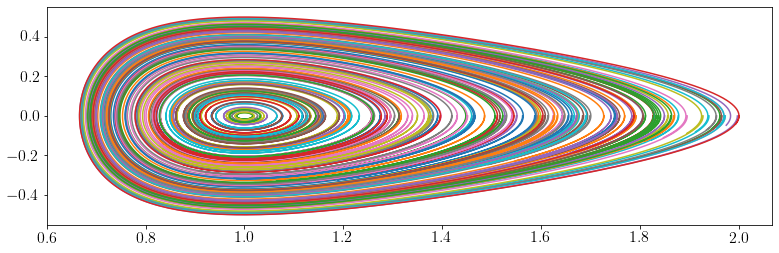

In [7]:
# Plot some of the training data for visualization

num_plot = 150

# Exact solution (from training data set)
data = data_train
exact = data[:num_plot, :, :]


fig = plt.figure(figsize=(13, 4)) 

# Plot "exact" solution from data
#  Training data shift the equilibrium to (0,0) so this plot shifts back to (1,0)
for j in np.arange(num_plot):
    plt.plot(exact[j,:,0]+1, exact[j,:,1]) 

plt.show() 

## Print training and validation losses

In [8]:
for dset, dtype in zip((data_val, data_train),
                        ['validation', 'training']):
    dset_pred = stack_predictions(dset, num_shifts)
    losses = actionangle.evaluate(x=dset, y=[dset, dset, dset_pred], batch_size=32, return_dict=True, verbose=0)
    print("Losses for {} data:".format(dtype))
    print(['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss'])
    for loss in losses:
        print(losses[loss], end=", ")
    print("\n")

Losses for validation data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.0006226120749488473, 6.353830394800752e-05, 6.284691335167736e-05, 0.0002350965514779091, 

Losses for training data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.0005042052362114191, 5.5340686230920255e-05, 5.505556327989325e-05, 0.00017870432930067182, 



## Plot training losses

In [13]:
# Load results from training
results_path = save_prefix + "initial_pool_results.json"
init_results = json.load(open(results_path))

results_path = save_prefix + "final_model_history.json"
final_results = json.load(open(results_path))

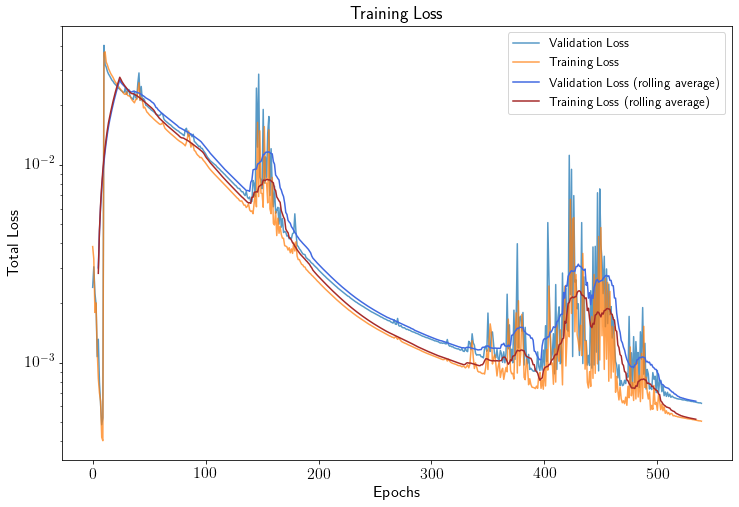

In [14]:
# Plot losses
best_model_idc = np.argmin(init_results['best_loss'])

train_loss = init_results['aec_hist'][best_model_idc]['loss'] + init_results['full_hist'][best_model_idc]['loss'] + final_results['loss']
val_loss = init_results['aec_hist'][best_model_idc]['val_loss'] + init_results['full_hist'][best_model_idc]['val_loss'] + final_results['val_loss']

train_loss = np.asarray(train_loss)
val_loss = np.asarray(val_loss)

roll_window = 20
train_roll = compute_rolling_average(train_loss, window=roll_window)
val_roll = compute_rolling_average(val_loss, window=roll_window)
roll_idcs = np.arange(train_loss.shape[0])[int(roll_window/4):-int(roll_window/4)]

plt.figure()

plt.semilogy(val_loss, label="Validation Loss", alpha=0.75)
plt.semilogy(train_loss, label="Training Loss", alpha=0.75)

plt.semilogy(roll_idcs, val_roll, color='royalblue', label="Validation Loss (rolling average)")
plt.semilogy(roll_idcs, train_roll, color='brown', label="Training Loss (rolling average)")

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend(loc='upper right')

plt.show()

## Plot Omega and Autoencoder Neural Network Outputs

In [19]:
data_val_flattened = tf.reshape(data_val, [-1, data_val.shape[-1]])
data_val_encoded = actionangle.inner_encoder(actionangle.outer_encoder(data_val_flattened))
radius_val = tf.reduce_sum(tf.square(data_val_encoded), axis=1, keepdims=True)
omegas_val = actionangle.auxiliary_network(radius_val)

Text(0, 0.5, 'Omega/Frequency')

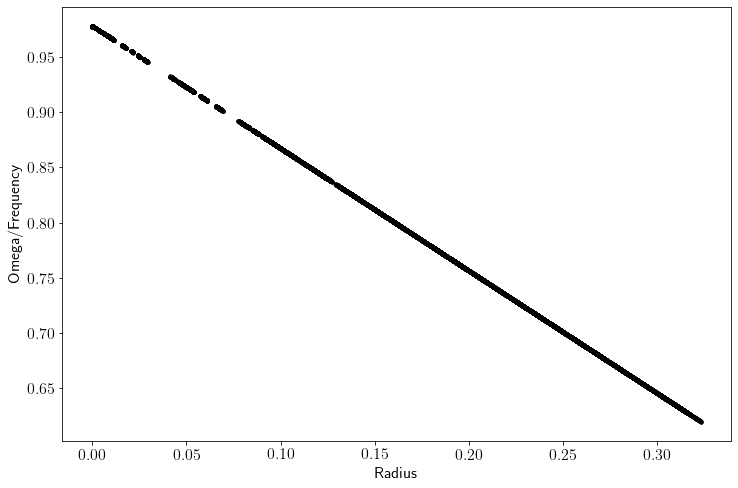

In [24]:
# Plot output of Omega neural network

plt.plot(radius_val, omegas_val,'k.')
plt.xlabel('Radius')
plt.ylabel('Omega/Frequency')

In [27]:
# Plot Action-Angle representation (should be near perfect circles)
plt.plot(data_val_encoded[:,0], data_val_encoded[:,1],'k.')
plt.xlabel('y1')
plt.ylabel('y2')

Text(0.5, 0, 'y_1')

RuntimeError: latex was not able to process the following string:
b'y_1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/jbramburger7/.matplotlib/tex.cache/b0113042bfe5916bda96ddfc69f4b783.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file b0113042bfe5916bda96ddfc69f4b783.aux.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily y_
                  1}
No pages of output.
Transcript written on b0113042bfe5916bda96ddfc69f4b783.log.




<Figure size 864x576 with 1 Axes>